# D'autres types d'agents...

In [7]:
from atom import *
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,10)

## ZIT avec des probabilités d'ask et de bid différentes

On peut créer des ZIT ayant des probabilités d'envoyer des asks / d'envoyer des bids différentes de $\dfrac{1}{2}$. On peut aussi choisir l'intervalle dans lequel il tirent le prix (initiallement $[\![1000,9999]\!]$) et la quantité (initiallement $[\![1,9]\!]$). Pour ce faire, on va utiliser les paramètres p_min, p_max, q_min, q_max, pb_ask et pb_bid. Si pb_ask + pb_bid < 1, alors le ZIT n'enverra aucun ordre avec une probabilité 1- (pb_ask + pb_bid).

In [8]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
t1 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.5, pb_bid=0.5)
t2 = ZITTrader(m, p_min=100, p_max=999, pb_ask=0.1, pb_bid=0.1)
m.add_trader(t1)
m.add_trader(t2)
for i in range(200):
    m.run_once()
m.print_state()
file.close()

print(t1.get_infos(m))
print(t2.get_infos(m))

ZIT 9:
Cash: -4073
Apple: 0
Wealth: -4073

ZIT 10:
Cash: 4073
Apple: 0
Wealth: 4073



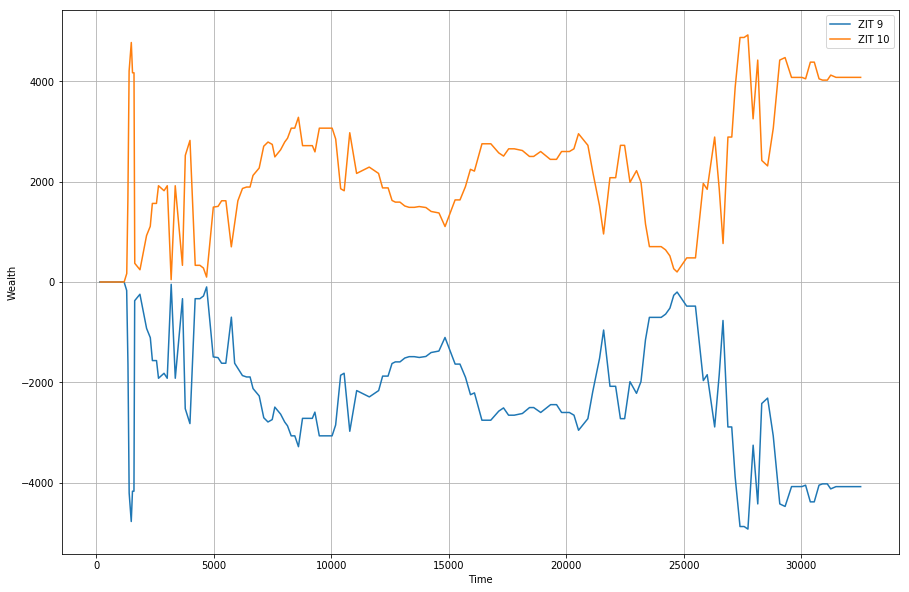

In [9]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

## ZIT ne se ruinant pas

Nos ZITs peuvent à la fois avoir un cash négatif et une quantité d'actions négative. Nous allons faire des ZIT qui ne se ruinent pas en respectant le principe suivant : un agent ne place pas d'ordre tant qu'il lui reste un ordre dans un carnet d'ordre.

In [10]:
class ZITTrader_v2(Trader):
    def __init__(self, market, initial_assets=None, cash=0):
        Trader.__init__(self, market, initial_assets, cash)
    def __str__(self):
        return "ZITv2 " + super().__str__()
    def decide_order(self, market, asset):
        # On compte le nombre d'ordres placés dans les orderbooks par cet agent...
        nb_placed_orders = sum(len([o for o in market.orderbooks[asset2].asks.tree+market.orderbooks[asset2].bids.tree if o.source == self]) for asset2 in market.orderbooks.keys())
        if nb_placed_orders == 0:
            direction = random.choice(['ASK', 'BID'])
            if direction == 'ASK' and self.assets[asset] > 0: # Si on a quantité > 0 d'actions pour cet asset...
                # On ne vend pas une quantité d'actions > à celle qu'on a.
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, min(self.assets[asset], 9)))
            elif direction == 'BID' and self.cash >= 1000: # Pour acheter, il faut de l'argent...
                price = random.randint(1000, min(self.cash, 9999))
                # On n'achète pas pour un volume > au cash qu'on a.
                return LimitOrder(asset, self, 'BID', price, random.randint(1, min(self.cash//price, 9)))
        return None # Dans tous les autres cas, on ne place pas d'ordre.

Remarque : La façon de compter le nombre d'ordres placés par l'agent n'est clairement pas optimisée. À chaque fois qu'il faut placer un ordre, on fait $\Theta(\sum_{a\in Assets}|\text{Orderbook}_a|)$ opérations... Il suffirait d'ajouter un attribut booléen à la classe `ZITTrader_v3` qui garde en mémoire si un ordre est placé, et qui est modifée par la méthode `market.match` dès que cet ordre est retiré d'un carnet d'ordre. Ce n'est pas fait ici, car c'est plus compliqué à faire, et on va voir que ces ZIT ne vont pas avoir un comportement satisfaisant, et donc on ne pas s'en servir.

On va vérifier que ce ZIT fait bien ce qu'on veut sur des exemples simples. On va d'abord regarder ce qu'il se passe si on initialise les agents sans cash ni actions. Ils ne devraient placer aucun ordre.

In [11]:
m = Market(['Apple'])
t = ZITTrader_v2(m)
m.add_trader(t)
m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZITv2 11;0;Apple:0
AgentWealth;ZITv2 11;0;310
Tick;1

# Nb orders received: 0
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 0


Des agents qui n'ont que du cash vont envoyer soit rien, soit des ordres bid.

In [12]:
m = Market(['Apple'])
t = ZITTrader_v2(m, cash=10000)
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZITv2 12;10000;Apple:0
AgentWealth;ZITv2 12;10000;223
LimitOrder;Apple;ZITv2 12;BID;7772;1
Tick;1
Tick;2
Tick;3

# Nb orders received: 1
# Nb fixed prices: 0
# Leaving ask size: 0
# Leaving bid size: 1


Des agents qui n'ont que des actions vont envoyer soit rien, soit des ordres ask.

In [13]:
m = Market(['Apple'])
t = ZITTrader_v2(m, initial_assets=[50])
m.add_trader(t)
for i in range(3):
    m.run_once()
m.print_state()

# LimitOrder;asset;agent;direction;price;qty
# CancelMyOrders;asset;agent
# Tick;nb_tick
# Price;asset;bider;asker;price;qty;timestamp(µs)
# NewAgent;name;cash;asset 1:qty 1,...,asset n:qty n
# Agent;name;cash;last_modified_asset;qty
# AgentWealth;agent;wealth;timestamp(µs)

NewAgent;ZITv2 13;0;Apple:50
AgentWealth;ZITv2 13;0;213
LimitOrder;Apple;ZITv2 13;ASK;7084;4
Tick;1
Tick;2
Tick;3

# Nb orders received: 1
# Nb fixed prices: 0
# Leaving ask size: 1
# Leaving bid size: 0


Maintenant qu'on sait que notre ZIT fonctionne comme on le veut, on va désormais faire une simulation avec plusieurs agents et plusieurs tours de parole et afficher les prix.

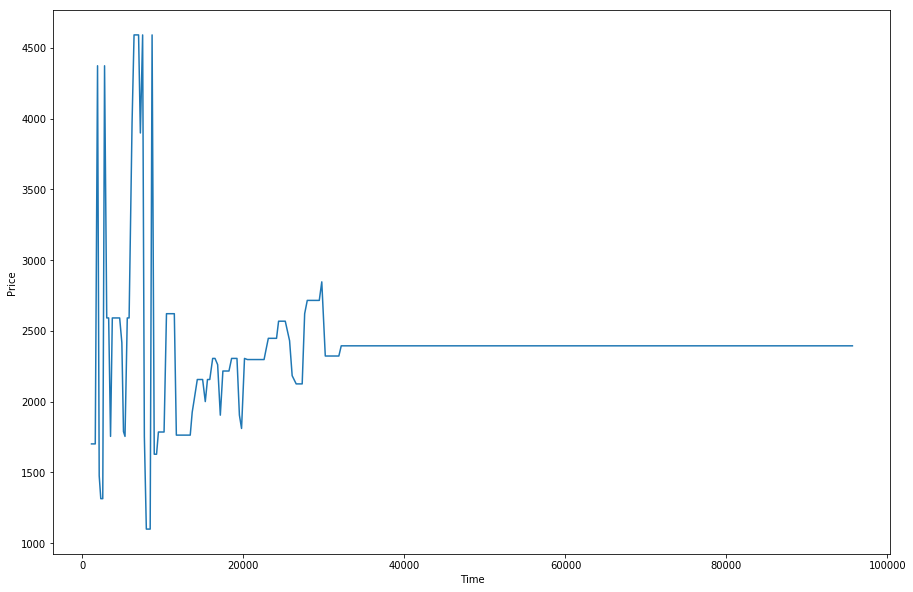

In [14]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
for i in range(100):
    m.add_trader(ZITTrader_v2(m, initial_assets=[50], cash=10000))
for i in range(100):
    m.run_once()
m.print_last_prices()
m.print_state()
file.close()

T, P = extract_prices('trace.dat')['Apple']
plt.plot(T, P, '-')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

Très rapidement, plus aucun prix n'est fixé, car chaque agent attend que son ordre soit exécuté.
On peut faire un `cat trace.dat | grep -E 'Price;|Tick;'` dans la console pour ne récupérer que les lignes commençant par "Tick;" ou par "Price;" pour voir quand ont été fixés les prix.

Remarque : Comme des lignes "Price;..." ne sont écrites que lorsqu'un prix est fixé, on est obligé de forcer le marché à afficher le dernier prix de l'asset (avec `m.print_last_prices()`) à la fin de la simulation pour voir que les prix n'évoluent plus à partir d'un certain moment. (Si on ne le faisait pas, on obtiendrait la même courbe, mais tronquée : on n'aurait pas la partie stationnaire.)

## Agent chartist

Un agent chartist possède deux paramètres $m < M$. En notant, $\widehat{p_t}(n)$ la moyenne des prix $p_{t-n}, \ldots, p_{t-1}$, l'agent choisi l'ordre à envoyer de la façon suivante :
* Si $\widehat{p_t}(m) > \widehat{p_t}(M)$, alors la tendance du prix est à la hausse et l'agent envoie un bid.
* Si $\widehat{p_t}(m) < \widehat{p_t}(M)$, alors la tendance du prix est à la baisse et l'agent envoie un ask.
* Si $\widehat{p_t}(m) = \widehat{p_t}(M)$, alors l'agent n'envoie pas d'ordre.

In [15]:
class Chartist(Trader):
    def __init__(self, market, initial_assets=None, cash=0, m=3, M=5):
        Trader.__init__(self, market, initial_assets, cash)
        self.m = m
        self.M = M
    def __str__(self):
        return "Chartist " + super().__str__()
    def decide_order(self, market, asset):
        def mean_price(n):
            P = market.prices_hist[asset]
            if len(P) >= n:
                s = sum([P[-i] for i in range(n)])
                return s/n
            return None
        mean_m = mean_price(self.m)
        mean_M = mean_price(self.M)
        if mean_m != None and mean_M != None:
            if mean_m > mean_M:
                return LimitOrder(asset, self, 'BID', random.randint(1000, 9999), random.randint(1, 9))
            elif mean_m < mean_M:
                return LimitOrder(asset, self, 'ASK', random.randint(1000, 9999), random.randint(1, 9))
        return None

In [16]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
for i in range(2):
    m.add_trader(Chartist(m))
for i in range(2):
    m.add_trader(ZITTrader(m))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

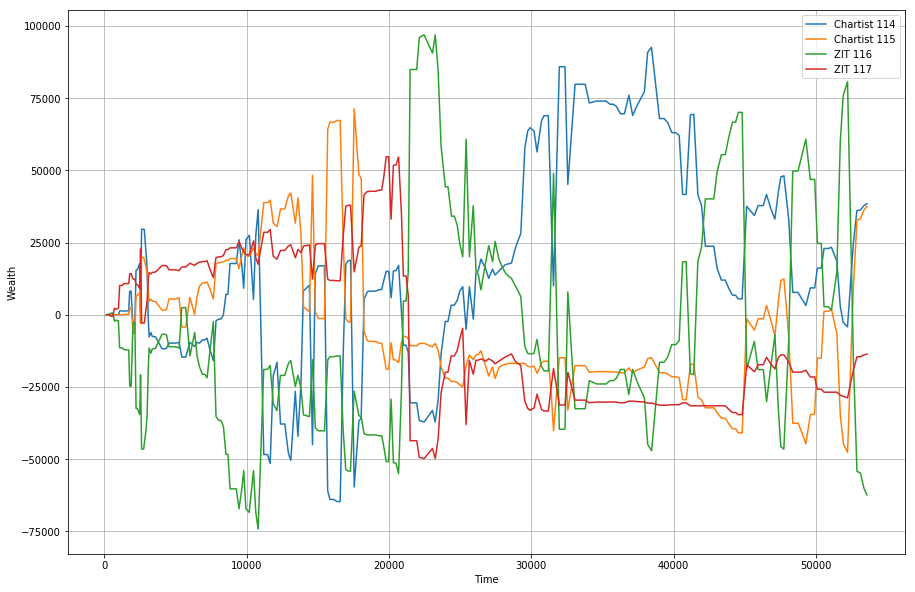

In [17]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

On va regarder si un chartist a en moyenne un wealth plus élevé qu'un ZIT :

In [18]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
for i in range(10):
    m.add_trader(Chartist(m, m=2, M=5))
for i in range(10):
    m.add_trader(ZITTrader(m))
for i in range(1000):
    m.run_once()
m.print_state()
file.close()

In [19]:
Wealths = extract_wealths('trace.dat')
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealths.keys():
    _, W = Wealths[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des chartists : %i\nWealth moyen des ZIT : %i\n" % (np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des chartists : -363758
Wealth moyen des ZIT : 363758



Nos chartists ont l'air de faire moins bien que des ZITs...

## Agent automate

On va créer un agent qui va prendre en paramètre un pile d'ordre et qui, à chaque fois qu'il aura la parole, renverra l'ordre au sommet de la pile.

In [20]:
class Automaton(Trader):
    def __init__(self, market, orders_dict=dict(), initial_assets=None, cash=0, name=None):
        '''orders_dict est un dictionnaire dont les clés sont les assets et les valeurs des listes de la forme (direction,price,qty)'''
        Trader.__init__(self, market, initial_assets, cash, name=name)
        self.orders = orders_dict
    def __str__(self):
        return self.name if self.name != None else "Automaton "+ super().__str__()
    def decide_order(self, market, asset):
        if asset not in self.orders.keys() or self.orders[asset] == []:
            return None
        else:
            d, p, q = self.orders[asset].pop(0)
            return LimitOrder(asset, self, d, p, q)

In [21]:
file = open('trace.dat', 'w')
m = Market(['Apple'], out=file)
# On ajoute un agent automate qui envoie en alternance un ordre de vente à 6000 et une ordre d'achat à 4000 (toujours avec une quantité de 9) 
m.add_trader(Automaton(m, orders_dict={'Apple': [('ASK', 6000, 9), ('BID', 4000, 9)]*50}, name='juliette'))
# On ajoute un autre agent automate qui envoie en alternance un ordre de vente à 4000 et une ordre d'achat à 6000 (toujours avec une quantité de 9) 
m.add_trader(Automaton(m, orders_dict={'Apple': [('ASK', 4000, 9), ('BID', 6000, 9)]*50}, name='paul'))
# On rajoute deux ZITs
for i in range(2):
    m.add_trader(ZITTrader(m))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

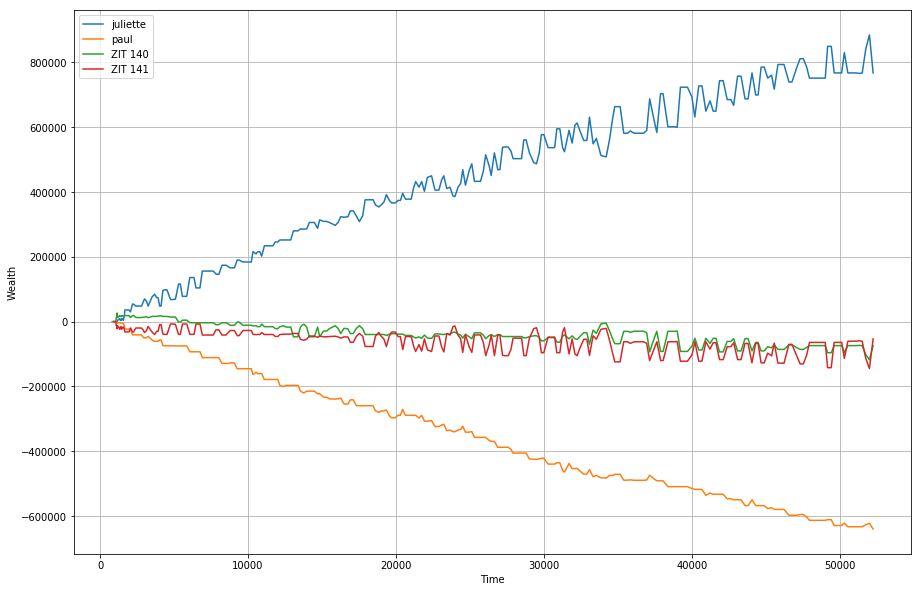

In [22]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.show()

On observe qu'un des deux automates a un wealth qui croît (c'est celui qui vend à 6000 et achète à 4000) et que l'autre décroît (celui qui vend à 4000 et achète à 6000).

## Agent arbitragist

In [23]:
class Arbitragist(Trader):
    def __init__(self, market, initial_assets=None, cash=0, period=2):
        Trader.__init__(self, market, initial_assets, cash)
        self.period = max(period, 2)
        self.time = period-1
    def __str__(self):
        return "Arbitragist " + super().__str__()
    def decide_order(self, market, asset):
        self.time += 1
        if self.time == self.period: # Si on a passé une période, on a annule tous nos ordres non encore exécutés
            self.time = 0
            return CancelMyOrders(asset, self)
        elif self.time == 1: # Si on vient d'annuler nos ordres, on envoie notre ordre...
            w = self.get_wealth(market)
            p = market.prices[asset]
            if p != None:
                q = w//(len(market.orderbooks.keys())*p) - self.assets[asset]
                # w//(len(market.orderbooks.keys())*p) représente la quantité d'actions de asset que l'agent devrait
                # avoir s'il voulait répartir équitablement tout son wealth sur l'ensemble des assets
                if q != 0:
                    return LimitOrder(asset, self, 'ASK' if q > 0 else 'BID', p, np.abs(q))
        return None

In [24]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file)
m.add_trader(ZITTrader(m, [5, 5, 5], cash=100000))
m.add_trader(Chartist(m, [5, 5, 5], cash=100000))
m.add_trader(Arbitragist(m, [5, 5, 5], cash=100000, period=10))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

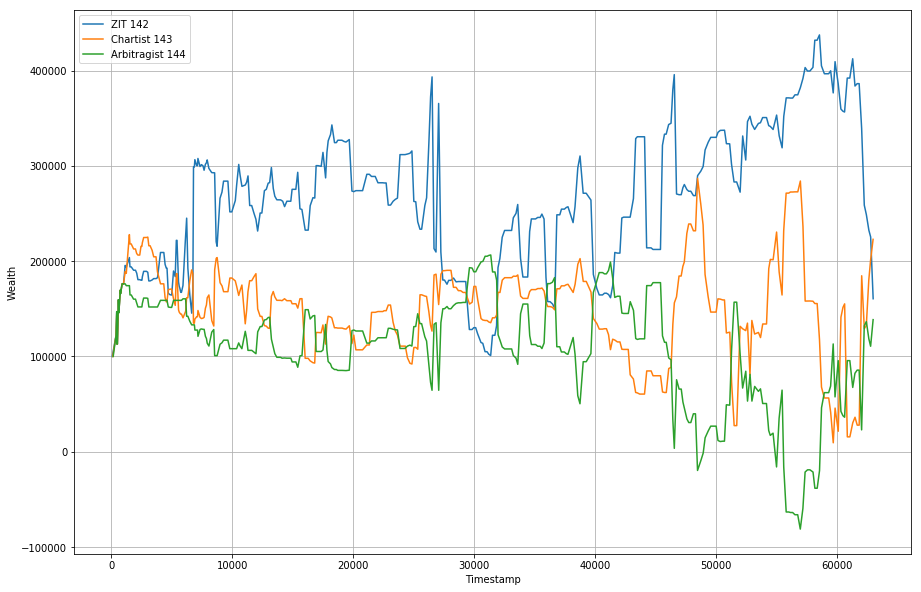

In [25]:
Wealths = extract_wealths('trace.dat')
for agent in Wealths.keys():
    T, W = Wealths[agent]
    plt.plot(T, W, '-', label=agent)
plt.legend(loc='best')
plt.grid()
plt.xlabel('Timestamp')
plt.ylabel('Wealth')
plt.show()

On va comparer les wealths moyens des chartists, arbitragists et des ZITs :

In [26]:
file = open('trace.dat', 'w')
m = Market(['Apple', 'Google', 'Microsoft'], out=file)
for i in range(20):
    m.add_trader(ZITTrader(m, [10, 10, 10], cash=10000))
    m.add_trader(Chartist(m, [10, 10, 10], cash=10000, m=2, M=5))
    m.add_trader(Arbitragist(m, [10, 10, 10], cash=10000, period=10))
for i in range(100):
    m.run_once()
m.print_state()
file.close()

In [27]:
Wealths = extract_wealths('trace.dat')
Mean_wealth_arbitragist = []
Mean_wealth_chartist = []
Mean_wealth_ZIT = []
for agent in Wealths.keys():
    _, W = Wealths[agent]
    if "Chartist" in agent:
        Mean_wealth_chartist.append(np.mean(np.array(W)))
    elif "Arbitragist" in agent:
        Mean_wealth_arbitragist.append(np.mean(np.array(W)))
    else:
        Mean_wealth_ZIT.append(np.mean(np.array(W)))
print("Wealth moyen des arbitragists : %i\nWealth moyen des chartists : %i\nWealth moyen des ZITs : %i\n" % (np.mean(np.array(Mean_wealth_arbitragist)), np.mean(np.array(Mean_wealth_chartist)), np.mean(np.array(Mean_wealth_ZIT))))

Wealth moyen des arbitragists : 69452
Wealth moyen des chartists : 132560
Wealth moyen des ZITs : 320559

